In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_cell_based_tiny_net, get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

import tqdm

2022-10-12 16:59:43.209261: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='../configs/nas-benchmark/algos/RANDOM.config', help="The path to the configuration.")
# parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./tmp/', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

68469
Namespace(arch_nas_dataset='../NAS-Bench-201-v1_1-096897.pth', channel=16, config_path='../configs/nas-benchmark/algos/RANDOM.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=68469, save_dir='./tmp/', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../NAS-Bench-201-v1_1-096897.pth
channel          : 16
config_path      : ../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 68469
save_dir         : ./tmp/
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


# Main

In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
if xargs.arch_nas_dataset is None:
    api = None
else:
    api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

logger.close()

Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/algos/RANDOM.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=250, current::epoch=0, iter=0.00, type=cosine, T-max=250, eta-min=0

In [5]:
# 250 ep weights
network_dict = torch.load("./250ep_supernet_weights.pth")
network.load_state_dict(network_dict)

# network_dict = torch.load("../results/three_metrics/test/checkpoint/seed-68228-basic.pth")['search_model']
# search_model.load_state_dict(network_dict)

<All keys matched successfully>

In [6]:
def valid_acc_metric(network, inputs, targets):
    with torch.no_grad():
        network.eval()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(
            logits.data, targets.data, topk=(1, 5)
        )
    return val_top1.item()

def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        network.eval()
        # accuracy
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        # robustness
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        return acc.item(), confidence.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.1)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.01)
    for i in range(10):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    
    # resume
    network.load_state_dict(original_dict)
    network.eval()
    
    for key in large_step_dict.keys():
#         if 'classifier' in key:
#             large_step = large_step_dict[key] - original_dict[key]
#             small_step = small_step_dict[key] - original_dict[key]
#             score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
#             score = score.mean().item() * 100 # in percent
#             break
        if 'stem.0.weight' in key:
            large_step = large_step_dict[key] - original_dict[key]
            small_step = small_step_dict[key] - original_dict[key]
            co, ci, kh, kw = large_step.size()
            large_step = large_step.view(co, -1)
            small_step = small_step.view(co, -1)
            score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
            score = score.mean().item() * 100 # in percent
            break
            
    return score
    

def search_find_best_my(xloader, network, criterion, n_samples):
    archs, metric_accs, metric_steps, metric_confidences, metric_robustnesses = [], [], [], [], []
    loader_iter = iter(xloader)
    for i in tqdm.tqdm(range(n_samples)):
        arch = network.module.random_genotype(True)
        try:
            inputs, targets = next(loader_iter)
        except:
            loader_iter = iter(xloader)
            inputs, targets = next(loader_iter)
        inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
#         valid_acc = valid_acc_metric(network, inputs, targets)
        valid_acc, confidence, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
        step_sim = step_sim_metric(network, criterion, inputs, targets)

        archs.append(arch)
        metric_accs.append(valid_acc)
        metric_steps.append(step_sim)
        metric_confidences.append(confidence)
        metric_robustnesses.append(robustness)

    return archs, metric_accs, metric_steps, metric_confidences, metric_robustnesses

    
archs, metric_accs, metric_steps, metric_confidences, metric_robustnesses = search_find_best_my(valid_loader, network, criterion, 250)

100%|██████████| 250/250 [07:35<00:00,  1.82s/it]


In [23]:
import scipy.stats as stats
rank_accs, rank_steps, rank_confidences, rank_robustnesses = stats.rankdata(metric_accs), stats.rankdata(metric_steps), stats.rankdata(metric_confidences), stats.rankdata(metric_robustnesses)
rank_agg = rank_accs+rank_steps+rank_confidences-rank_robustnesses
rank_agg = rank_accs+rank_confidences-rank_robustnesses
best_idx = np.argmax(rank_agg)


best_arch, best_acc, best_step, best_conf, best_robust = archs[best_idx], metric_accs[best_idx], metric_steps[best_idx], metric_confidences[best_idx], metric_robustnesses[best_idx]
# log
print("RANDOM-NAS finds the best one : {:} with accuracy={:.2f}%, step_sim={:.2f}%, confidence={:.3f}%, robustness={:.3f}".format(best_arch, best_acc, best_step, best_conf, best_robust))
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=60.16%, step_sim=73.68%, confidence=48.421%, robustness=-0.037
Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
|nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=8590
cifar10-valid  FLOP=117.88 M, Params=0.830 MB, latency=19.78 ms.
cifar10-valid  train : [loss = 0.002, top1 = 99.98%], valid : [loss = 0.529, top1 = 89.72%]
cifar10        FLOP=117.88 M, Params=0.830 MB, latency=19.78 ms.
cifar10        train : [loss 

In [14]:
def get_valid_acc_from_api(api, arch):
    # print(api.query_by_arch(arch, "200"))
    index = api.query_index_by_arch(arch)
    results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    acc = 0
    for seed, result in results.items():
        acc = acc + result.get_eval('valid')['accuracy']
    acc = acc / len(results)
    return acc

api_valid_accs = [get_valid_acc_from_api(api, a) for a in archs]

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|skip_connect~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=14351, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14351, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|skip_connect~1|none~2|)
Call query_by_index with arch_index=15280, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=15280, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=15172, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=15172, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|none~1|skip_connect~2|)
Ca

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=10288, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10288, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=5488, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5488, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=10578, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10578, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|none~1|nor_conv_3x3~

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=6370, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6370, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=3642, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=3642, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=2964, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2964, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|avg_pool_3x3~1|+|none~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_in

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|avg_pool_3x3~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=8881, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8881, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_1x1~0|none~1|none~2|)
Call query_by_index with arch_index=11581, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11581, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|none~1|+|none~0|avg_pool_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=7142, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=7142, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=8,

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|none~2|)
Call query_by_index with arch_index=4412, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4412, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=10188, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10188, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|skip_connect~0|skip_connect~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=11595, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11595, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|none~2|)
Call

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|nor_conv_1x1~1|+|avg_pool_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=4828, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4828, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|)
Call query_by_index with arch_index=7892, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=7892, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|none~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=8682, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8682, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|avg_pool_3x3~2|)
Call query_by_index with

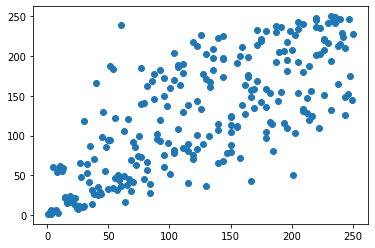

0.5482783245585516 6.256539155125381e-38


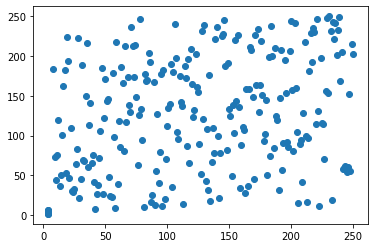

0.2014881094131254 2.0976239798945065e-06


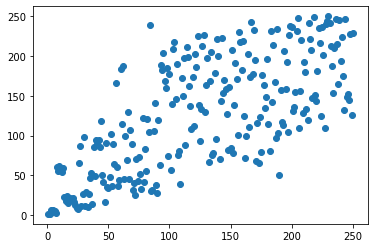

0.517896157573573 3.2179832439311253e-34


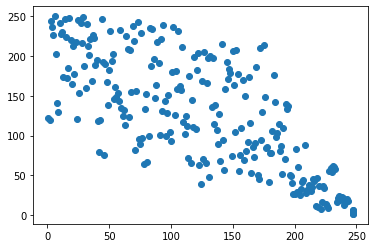

-0.5671814750061291 1.1289878630147562e-40


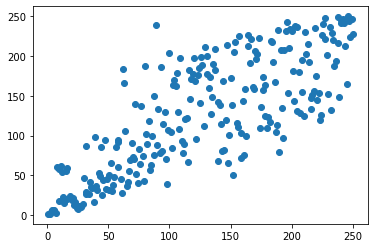

0.6108352634325391 6.87468798690986e-47


In [24]:
import matplotlib.pyplot as plt
import scipy.stats as stats

x = stats.rankdata(metric_accs)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_steps)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_confidences)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_robustnesses)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [10]:
for i in range(100):
    print(metric_robustnesses[i])
    print(api_valid_accs[i])
    print("\n\n")

-0.001906641642563045
80.90399998046875



-0.026249829679727554
87.38666666503906



-0.019661961123347282
87.00400000976562



-0.007951337844133377
83.56400001098632



-0.012038255110383034
88.732



-0.025033865123987198
85.99800000732422



-0.022478267550468445
87.86533332763672



-0.009542634710669518
86.27066667317708



-0.008005068637430668
85.9679999975586



-0.017294108867645264
89.01599998128255



-0.029859591275453568
85.72599999877929



-0.025877607986330986
89.1319999934896



-0.03525691479444504
90.81599997070313



-0.038931041955947876
87.52200000488281



-0.01445743814110756
88.72599998168945



-0.030319994315505028
89.53599999267578



-0.020330240949988365
87.2173333211263



-0.03612416237592697
88.48933333170572



-0.0038140369579195976
77.66399997558594



-0.03381376713514328
89.26666666259764



-2.8937831302755512e-05
72.26000001342774



-0.02253459393978119
87.53066666178385



-0.03471370041370392
91.00799998168947



8.94562930398024e-08
9.71199